# Summary statistics

`ScmRun` objects have methods specific to calculating summary statistics. In this notebook we demonstrate them.

In [1]:
# NBVAL_IGNORE_OUTPUT
import traceback

import matplotlib.pyplot as plt
import numpy as np

from scmdata.run import ScmRun, run_append

In [2]:
plt.rcParams["figure.figsize"] = (12, 8)

## Helper bits and piecs

In [3]:
def new_timeseries(
    n=101,
    count=1,
    model="example",
    scenario="ssp119",
    variable="Surface Temperature",
    unit="K",
    region="World",
    cls=ScmRun,
    **kwargs,
):
    data = np.random.rand(n, count) * np.arange(n)[:, np.newaxis]
    index = 2000 + np.arange(n)
    return cls(
        data,
        columns={
            "model": model,
            "scenario": scenario,
            "variable": variable,
            "region": region,
            "unit": unit,
            **kwargs,
        },
        index=index,
    )

Let's create an `ScmRun` which contains a few variables and a number of runs. Such a dataframe would be used to store the results from an ensemble of simple climate model runs.

In [4]:
# NBVAL_IGNORE_OUTPUT
runs = run_append(
    [
        new_timeseries(
            count=3,
            variable=[
                "Surface Temperature",
                "Atmospheric Concentrations|CO2",
                "Radiative Forcing",
            ],
            unit=["K", "ppm", "W/m^2"],
            run_id=run_id,
        )
        for run_id in range(10)
    ]
)
runs.metadata["source"] = "fake data"
runs

<scmdata.ScmRun (timeseries: 30, timepoints: 101)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	      model region  run_id scenario   unit                        variable
	0   example  World       0   ssp119      K             Surface Temperature
	1   example  World       0   ssp119    ppm  Atmospheric Concentrations|CO2
	2   example  World       0   ssp119  W/m^2               Radiative Forcing
	3   example  World       1   ssp119      K             Surface Temperature
	4   example  World       1   ssp119    ppm  Atmospheric Concentrations|CO2
	5   example  World       1   ssp119  W/m^2               Radiative Forcing
	6   example  World       2   ssp119      K             Surface Temperature
	7   example  World       2   ssp119    ppm  Atmospheric Concentrations|CO2
	8   example  World       2   ssp119  W/m^2               Radiative Forcing
	9   example  World       3   ssp119      K             Surface Temperature
	10  example  World       3   ssp119    ppm  At

## `process_over`

The `process_over` method allows us to calculate a specific set of statistics.

In [5]:
print(runs.process_over.__doc__)


        Process the data over the input columns.

        Parameters
        ----------
        cols
            Columns to perform the operation on. The timeseries will be grouped by all
            other columns in :attr:`meta`.

        operation : ['median', 'mean', 'quantile']
            The operation to perform. This uses the equivalent pandas function. Note
            that quantile means the value of the data at a given point in the cumulative
            distribution of values at each point in the timeseries, for each timeseries
            once the groupby is applied. As a result, using ``q=0.5`` is is the same as
            taking the median and not the same as taking the mean/average.

        na_override: [int, float]
            Convert any nan value in the timeseries meta to this value during processsing.
            The meta values converted back to nan's before the dataframe is returned. This
            should not need to be changed unless the existing metadata cla

### Mean

In [6]:
# NBVAL_IGNORE_OUTPUT
mean = runs.process_over(cols="run_id", operation="mean")
mean

,,,,time,2000-01-01,2001-01-01,2002-01-01,2003-01-01,2004-01-01,2005-01-01,2006-01-01,2007-01-01,2008-01-01,2009-01-01,...,2091-01-01,2092-01-01,2093-01-01,2094-01-01,2095-01-01,2096-01-01,2097-01-01,2098-01-01,2099-01-01,2100-01-01
variable,scenario,model,unit,region,,,,,,,,,,,,,,,,,,,,,
Atmospheric Concentrations|CO2,ssp119,example,ppm,World,0.0,0.421687,0.968404,1.323689,1.990493,2.326791,4.124574,3.667312,4.110383,4.386854,...,34.809542,33.851556,64.702380,52.833653,39.854411,44.217992,50.089046,50.539782,53.457311,69.645938
Radiative Forcing,ssp119,example,W/m^2,World,0.0,0.559220,0.605883,1.598295,1.321246,2.783086,3.044953,4.397936,3.866672,4.635974,...,54.638006,43.087724,58.534180,54.647495,43.382883,42.894430,54.074702,59.736007,50.607818,51.902253
Surface Temperature,ssp119,example,K,World,0.0,0.636440,1.176011,1.528110,2.055076,1.884160,3.367938,3.212646,4.094471,6.224084,...,59.063382,48.593141,50.657593,48.771039,69.268124,47.501668,49.044738,28.268334,49.595552,44.175341


### Median

In [7]:
# NBVAL_IGNORE_OUTPUT
median = runs.process_over(cols="run_id", operation="median")
median

,,,,time,2000-01-01,2001-01-01,2002-01-01,2003-01-01,2004-01-01,2005-01-01,2006-01-01,2007-01-01,2008-01-01,2009-01-01,...,2091-01-01,2092-01-01,2093-01-01,2094-01-01,2095-01-01,2096-01-01,2097-01-01,2098-01-01,2099-01-01,2100-01-01
variable,scenario,model,unit,region,,,,,,,,,,,,,,,,,,,,,
Atmospheric Concentrations|CO2,ssp119,example,ppm,World,0.0,0.385331,0.949475,1.407393,2.296655,2.782576,4.798089,4.327890,4.255960,3.805612,...,33.241199,37.623741,72.954209,46.478614,37.011912,42.193501,57.199325,55.272703,53.922541,68.739077
Radiative Forcing,ssp119,example,W/m^2,World,0.0,0.619339,0.497598,1.694091,1.061635,2.545489,2.986798,5.063652,3.908060,5.503760,...,60.550598,35.888395,66.387306,47.789563,42.296888,30.268578,54.073277,62.600605,58.842108,51.981219
Surface Temperature,ssp119,example,K,World,0.0,0.693709,1.143539,1.504152,2.000189,1.376956,3.151302,2.805797,4.983162,6.266407,...,61.112283,59.111004,59.719545,50.253838,77.193125,46.564196,35.770305,25.745385,42.278518,44.539013


### Other quantiles

In [8]:
# NBVAL_IGNORE_OUTPUT
lower_likely_quantile = runs.process_over(
    cols="run_id", operation="quantile", q=0.17
)
lower_likely_quantile

,,,,time,2000-01-01,2001-01-01,2002-01-01,2003-01-01,2004-01-01,2005-01-01,2006-01-01,2007-01-01,2008-01-01,2009-01-01,...,2091-01-01,2092-01-01,2093-01-01,2094-01-01,2095-01-01,2096-01-01,2097-01-01,2098-01-01,2099-01-01,2100-01-01
variable,scenario,model,unit,region,,,,,,,,,,,,,,,,,,,,,
Atmospheric Concentrations|CO2,ssp119,example,ppm,World,0.0,0.204980,0.615980,0.440646,1.006538,0.651718,2.537007,0.389093,2.232411,2.706572,...,11.836308,9.374395,46.739399,28.762281,14.405461,30.019882,20.547347,21.574863,22.627569,51.700433
Radiative Forcing,ssp119,example,W/m^2,World,0.0,0.238321,0.100786,0.549976,0.135252,1.550723,0.894373,2.224966,1.080002,1.324221,...,36.109348,18.155648,44.080684,30.498201,26.865178,19.017708,38.680416,50.952162,23.654091,18.588638
Surface Temperature,ssp119,example,K,World,0.0,0.342312,0.691182,0.381126,0.845751,0.597451,2.104708,1.176607,1.040005,4.251082,...,37.546532,17.948390,17.955357,18.704759,46.630340,16.046633,20.627084,3.730808,22.548632,20.528425


## `quantiles_over`

If you want to calculate more than one summary statistic, `quantiles_over` will calculate and label multiple summary statistics before returning them.

In [9]:
print(runs.quantiles_over.__doc__)


        Calculate quantiles of the data over the input columns.

        Parameters
        ----------
        cols
            Columns to perform the operation on. The timeseries will be grouped by all
            other columns in :attr:`meta`.

        quantiles
            The quantiles to calculate. This should be a list of quantiles to calculate
            (quantile values between 0 and 1). ``quantiles`` can also include the strings
            "median" or "mean" if these values are to be calculated.

        **kwargs
            Passed to :meth:`~ScmRun.process_over`.

        Returns
        -------
        :obj:`pandas.DataFrame`
            The quantiles of the timeseries, grouped by all columns in :attr:`meta`
            other than :obj:`cols`. Each calculated quantile is given a label which is
            stored in the ``quantile`` column within the output index.

        Raises
        ------
        TypeError
            ``operation`` is included in ``kwargs``. The oper

In [10]:
# NBVAL_IGNORE_OUTPUT
summary_stats = runs.quantiles_over(
    cols="run_id", quantiles=[0.05, 0.17, 0.5, 0.83, 0.95, "mean", "median"]
)
summary_stats

,,,,,time,2000-01-01,2001-01-01,2002-01-01,2003-01-01,2004-01-01,2005-01-01,2006-01-01,2007-01-01,2008-01-01,2009-01-01,...,2091-01-01,2092-01-01,2093-01-01,2094-01-01,2095-01-01,2096-01-01,2097-01-01,2098-01-01,2099-01-01,2100-01-01
variable,scenario,model,unit,region,quantile,,,,,,,,,,,,,,,,,,,,,
Atmospheric Concentrations|CO2,ssp119,example,ppm,World,0.05,0.0,0.106378,0.454474,0.108881,0.422071,0.290417,1.169669,0.295627,0.549038,2.452372,...,7.290509,0.844988,33.036537,21.637909,9.468777,12.483263,11.200956,8.604742,12.595982,45.031076
Radiative Forcing,ssp119,example,W/m^2,World,0.05,0.0,0.113854,0.033900,0.313981,0.066578,1.176137,0.627283,1.437307,0.366304,0.349898,...,21.205060,7.711100,16.253143,25.858920,11.147328,12.270536,16.874640,33.789110,15.390355,17.602846
Surface Temperature,ssp119,example,K,World,0.05,0.0,0.126904,0.504047,0.041131,0.461670,0.465090,1.513675,0.591785,0.156288,4.070927,...,11.221463,6.844620,7.794035,14.459257,26.800170,5.701258,19.041378,0.578940,13.626871,5.772624
Atmospheric Concentrations|CO2,ssp119,example,ppm,World,0.17,0.0,0.204980,0.615980,0.440646,1.006538,0.651718,2.537007,0.389093,2.232411,2.706572,...,11.836308,9.374395,46.739399,28.762281,14.405461,30.019882,20.547347,21.574863,22.627569,51.700433
Radiative Forcing,ssp119,example,W/m^2,World,0.17,0.0,0.238321,0.100786,0.549976,0.135252,1.550723,0.894373,2.224966,1.080002,1.324221,...,36.109348,18.155648,44.080684,30.498201,26.865178,19.017708,38.680416,50.952162,23.654091,18.588638
Surface Temperature,ssp119,example,K,World,0.17,0.0,0.342312,0.691182,0.381126,0.845751,0.597451,2.104708,1.176607,1.040005,4.251082,...,37.546532,17.948390,17.955357,18.704759,46.630340,16.046633,20.627084,3.730808,22.548632,20.528425
Atmospheric Concentrations|CO2,ssp119,example,ppm,World,0.5,0.0,0.385331,0.949475,1.407393,2.296655,2.782576,4.798089,4.327890,4.255960,3.805612,...,33.241199,37.623741,72.954209,46.478614,37.011912,42.193501,57.199325,55.272703,53.922541,68.739077
Radiative Forcing,ssp119,example,W/m^2,World,0.5,0.0,0.619339,0.497598,1.694091,1.061635,2.545489,2.986798,5.063652,3.908060,5.503760,...,60.550598,35.888395,66.387306,47.789563,42.296888,30.268578,54.073277,62.600605,58.842108,51.981219
Surface Temperature,ssp119,example,K,World,0.5,0.0,0.693709,1.143539,1.504152,2.000189,1.376956,3.151302,2.805797,4.983162,6.266407,...,61.112283,59.111004,59.719545,50.253838,77.193125,46.564196,35.770305,25.745385,42.278518,44.539013


### Plotting

#### Calculate quantiles within plotting function

We can use `plumeplot` directly to plot quantiles. This will calculate the quantiles as part of making the plot so if you're doing this lots it might be faster to pre-calculate the quantiles, then make the plot instead (see below)

Note that in this case the default setttings in `plumeplot` don't produce anything that helpful, we show how to modify them in the cell below.

(<AxesSubplot:>,
  <matplotlib.lines.Line2D at 0x7f4f1c00b370>])

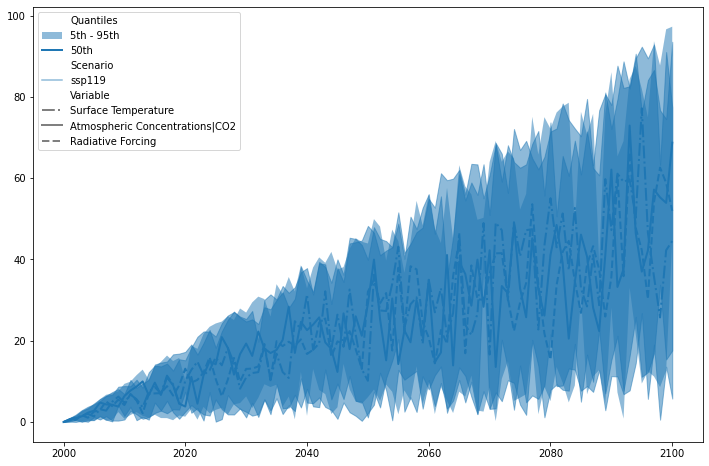

In [11]:
# NBVAL_IGNORE_OUTPUT
runs.plumeplot(quantile_over="run_id")

(<AxesSubplot:>,
  <matplotlib.lines.Line2D at 0x7f4f1bf92a00>])

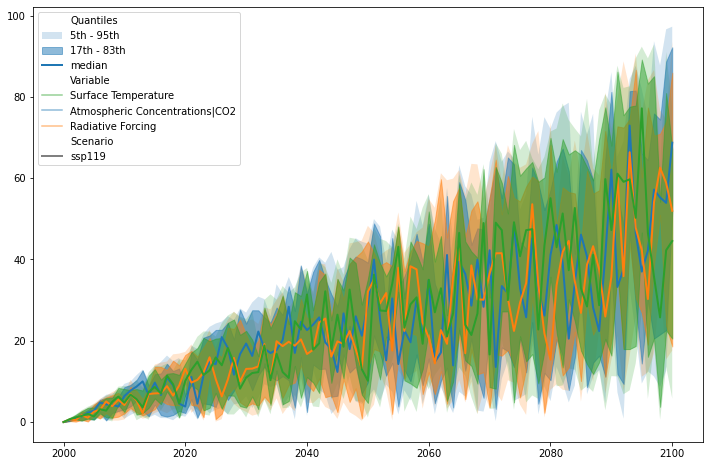

In [12]:
# NBVAL_IGNORE_OUTPUT
runs.plumeplot(
    quantile_over="run_id",
    quantiles_plumes=[
        ((0.05, 0.95), 0.2),
        ((0.17, 0.83), 0.5),
        (("median",), 1.0),
    ],
    hue_var="variable",
    hue_label="Variable",
    style_var="scenario",
    style_label="Scenario",
)

#### Pre-calculated quantiles

Alternately, we can cast the output of `quantiles_over` to an `ScmRun` object for ease of filtering and plotting.

In [13]:
# NBVAL_IGNORE_OUTPUT
summary_stats_scmrun = ScmRun(summary_stats)
summary_stats_scmrun

<scmdata.ScmRun (timeseries: 21, timepoints: 101)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	      model quantile region scenario   unit                        variable
	0   example     0.05  World   ssp119    ppm  Atmospheric Concentrations|CO2
	1   example     0.05  World   ssp119  W/m^2               Radiative Forcing
	2   example     0.05  World   ssp119      K             Surface Temperature
	3   example     0.17  World   ssp119    ppm  Atmospheric Concentrations|CO2
	4   example     0.17  World   ssp119  W/m^2               Radiative Forcing
	5   example     0.17  World   ssp119      K             Surface Temperature
	6   example      0.5  World   ssp119    ppm  Atmospheric Concentrations|CO2
	7   example      0.5  World   ssp119  W/m^2               Radiative Forcing
	8   example      0.5  World   ssp119      K             Surface Temperature
	9   example     0.83  World   ssp119    ppm  Atmospheric Concentrations|CO2
	10  example     0.83  World   ssp11

As discussed above, casting the output of `quantiles_over` to an `ScmRun` object helps avoid repeatedly calculating the quantiles.

(<AxesSubplot:>,
  <matplotlib.lines.Line2D at 0x7f4f1beee8b0>])

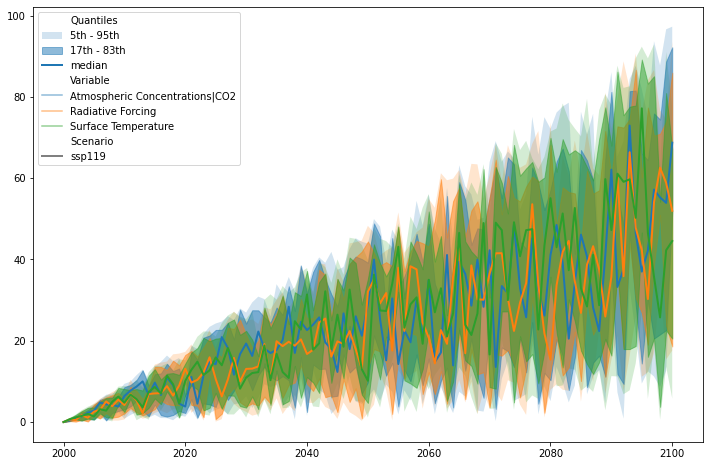

In [14]:
# NBVAL_IGNORE_OUTPUT
summary_stats_scmrun.plumeplot(
    quantiles_plumes=[
        ((0.05, 0.95), 0.2),
        ((0.17, 0.83), 0.5),
        (("median",), 1.0),
    ],
    hue_var="variable",
    hue_label="Variable",
    style_var="scenario",
    style_label="Scenario",
    pre_calculated=True,
)

If we don't want a plume plot, we can always our standard lineplot method.

<AxesSubplot:xlabel='time', ylabel='W/m^2'>

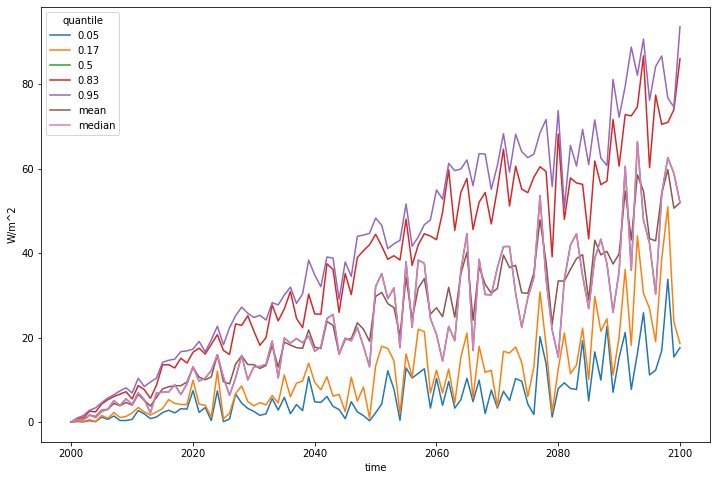

In [15]:
# NBVAL_IGNORE_OUTPUT
summary_stats_scmrun.filter(variable="Radiative Forcing").lineplot(
    hue="quantile"
)